In [3]:
import Pkg 
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("NLS_Solver")
Pkg.add("ForwardDiff")
Pkg.add("JSON")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [682c06a0] + JSON v0.21.4
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [64]:
using NLS_Solver

domain = range(1.0, 10.0, length=100)
image = map(x -> 1/x + 2 + 3 * x, domain) 

A = [domain image]

n_params = 3 
n_samples = size(A)[1]

function model(x::Real, params::AbstractVector)
    return params[1] * 1/x + params[2] + params[3] * x 
end

function residue(X::AbstractVector, Y::AbstractVector, params::AbstractVector)
        map(zip(X, Y)) do (x, y) 
            (model(x, params) - y) 
        end
end

nls = create_NLS_problem_using_ForwardDiff(params -> residue(A[:,1], A[:, 2], params), n_params => n_samples)

result = solve(nls, [1.0, 1.0, 1.0], LevenbergMarquardt_Conf())

LevenbergMarquardt_Result{Float64}(true, 8, 7.284737645639428e-21, [1.0000000001137384, 1.999999999928923, 3.0000000000074656])

In [23]:
using CSV, DataFrames

# Corresponds to query https://dune.com/queries/3087337
# Profuces DataFrame with columns ["volume", "fee", "mean_fee"]
function dex_fee_and_volume(path)
    token_pairs = []
    for file in readdir(path)
        filename = split(file, ".")[1]
        filepath = joinpath(path, file)
        df = CSV.read(filepath, DataFrame, types=[String, Float64, Float64], silencewarnings=true)

        df = df[.!ismissing.(df.fee), :]
        df.fee = abs.(df.fee)
        df.mean_fee = df.fee ./ df.dollar_value_sold
        df.volume = copy(df.dollar_value_sold)
        select!(df, Not(:dollar_value_sold))

        df = sort(df, :volume, rev=true)
        push!(token_pairs, (filename, df))
        
    end

    return Dict(token_pairs)
end 

dex_fee_and_volume_df = dex_fee_and_volume("../queries/dex_fee_and_volume")

using Plots

for token_pair in keys(dex_fee_and_volume_df)
    token_pair_df = dex_fee_and_volume_df[token_pair][1:6,:]
    plot = bar(token_pair_df.market, token_pair_df.volume,  yaxis="Volume", xaxis="Market", size=(800, 400), legend=false)
    plot!(twinx(), token_pair_df.market, token_pair_df.mean_fee,  yaxis="Mean Fee",  size=(800, 400), color=:red, legend=false)
    savefig(joinpath("..", "output", "dex_fee_and_volume", "plot_" * token_pair * ".png"))
end


In [24]:
using CSV, DataFrames
# Corresponds to queries under the category https://dune.com/queries/3106546
# Produces DataFrame with columns ["token_pair", "total_volume"]
function dex_market_shares(path)
    ranking = []
    for file in readdir(path)
        filename = split(file, ".")[1]
        filepath = joinpath(path, file)
        df = CSV.read(filepath, DataFrame, types=[String, Float64], silencewarnings=true)

        df = sort(df, Not(Symbol(filename)), rev=true) # Sort by the numerical column
        push!(ranking, (filename, df))
        
    end
    return Dict(ranking)
end 

dex_market_shares_df = Dict(
    "fees"=> dex_market_shares("../queries/market_share/fees"), 
    "volume"=> dex_market_shares("../queries/market_share/volume")
)

using Plots


for dependent_var in keys(dex_market_shares_df)
    for category in keys(dex_market_shares_df[dependent_var])
        category_df = dex_market_shares_df[dependent_var][category]
        # remove negative entries
        category_df = category_df[category_df[!,2] .> 0, :]
        plot = pie(category_df[1:10,1], category_df[1:10,2], title=dependent_var * " by " * category, legend=true)
        savefig(joinpath("..", "output", "market_share", dependent_var, "plot_" * category * ".png"))
    end
end

In [25]:
using CSV, DataFrames

# Corresponds to query https://dune.com/queries/3106936
# Produces DataFrame with columns ["amount_usd", "mean_fee"]
function trades_amountusd_fee(path)
    token_venue = []
    for file in readdir(path)
        filename = split(file, ".")[1]
        filepath = joinpath(path, file)
        df = CSV.read(filepath, DataFrame, types=[Float64, Float64], silencewarnings=true)

        df = df[.!ismissing.(df.fee), :]
        df.mean_fee = df.fee ./ df.dollar_value_sold
        select!(df, Not(:fee))

        push!(token_venue, (filename, df))
    end

    return Dict(token_venue)
end 

trades_amountusd_fee_df = trades_amountusd_fee("../queries/trades/amountusd_fee")

using Plots, NLS_Solver

for token_venue in keys(trades_amountusd_fee_df)
    token_pair, venue = split(token_venue, "_")
    token_venue_df = trades_amountusd_fee_df[token_venue]
    plot = scatter(token_venue_df.amount_usd, token_venue_df.mean_fee, title=token_pair * " on " * venue, legend=false)
end

LoadError: ArgumentError: column name :fee not found in the data frame

In [24]:
using JSON, DataFrames
using Base.MathConstants

function sqrtPriceX96ToFloat(sqrtPriceX96::BigInt, decimalsToken0::Int)
    numerator1 = sqrtPriceX96 * sqrtPriceX96
    numerator2 = BigInt(10) ^ decimalsToken0
    return numerator1 * numerator2 / (BigInt(2) ^ 192)
end
# Corresponds to Graph Protocol query fetch_uniswapv3_pool
# Produces DataFrame with columns ["amount_usd", "mean_fee"]
function graph_uniswapv3_pools(path)
    token_venue = []
    for file in readdir(path)
        filename = split(file, ".")[1]
        filepath = joinpath(path, file)
        
        json = JSON.parsefile(filepath)
        df = DataFrame(timestamp = Int64[], amount_usd = Float32[], fee_tier = Int64[], price = Float64[])
        for entry in json 
            push!(df, Dict(:timestamp => parse(Int, entry["timestamp"]), :amount_usd => parse(Float32, entry["amountUSD"]), :fee_tier => parse(Int, entry["pool"]["feeTier"]), :price => sqrtPriceX96ToFloat(parse(BigInt, entry["sqrtPriceX96"]), 18)))
        end

        push!(token_venue, (filename, df))
    end

    return Dict(token_venue)
end 

graph_uniswapv3_pools_df = graph_uniswapv3_pools("../queries/graph_protocol/uniswapv3_pool_fees")

# Separate between trades with fees charged from those without


using Plots

# Output graph for fee distribution timeseries 
for token_pair in keys(graph_uniswapv3_pools_df)
    df = graph_uniswapv3_pools_df[token_pair]
    # Aggregate timestamp by day
    df.day = floor.(Int64, df.timestamp ./ (24 * 60 * 60))
    df = combine(groupby(df, [:day, :fee_tier]), :amount_usd => sum)
    # plot timeseries with area chart colored by fee tier
    areaplot(df.day, df.amount_usd_sum, group=df.fee_tier, title=token_pair, legend=:topleft)
    savefig(joinpath("..", "output", "graph_protocol", "uniswapv3_pool_fees", "plot_" * token_pair * ".png"))
end

df[1:5, :] = 5×3 DataFrame
 Row │ day    fee_tier  amount_usd_sum
     │ Int64  Int64     Float32
─────┼─────────────────────────────────
   1 │ 19632       500       1.32541e7
   2 │ 19645       500       3.62242e6
   3 │ 19657       500       9.05356e6
   4 │ 19650       500       5.72713e6
   5 │ 19654       500       1.85076e7
df[1:5, :] = 5×3 DataFrame
 Row │ day    fee_tier  amount_usd_sum
     │ Int64  Int64     Float32
─────┼─────────────────────────────────
   1 │ 19597       500       4.96278e5
   2 │ 19290      3000       3.5117e5
   3 │ 19368       500       6.66303e5
   4 │ 19272       500       4.29847e5
   5 │ 19292       500       8.03799e5


We analyze on-chain trace of token transfers to identify fees generated via Uniswap v3 frontend fee. 

Below are addresses of note:

| Address | Description |
| --- | --- |
| 0x2008b6c3D07B061A84F790C035c2f6dC11A0be70 | Fee Layer (Native - PMM1) |
| 0x6000da47483062A0D734Ba3dc7576Ce6A0B645C4 | Uniswap Dutch Order Reactor |
| 0x3B9260A928D30F2A069572805FbB6880FC719A19 | Uniswap WETH Unwrapper |
| 0x37a8f295612602f2774d331e562be9e61B83a327 | Fee Vault |


In [5]:
using JSON, Dates, CSV, DataFrames

# ---------------- DATA PROCESSING ----------------
function analyze_data(path::String)
    # Load prices data from CSV file if not yet loaded
    # if !isdefined(Main, :prices_df_path) || prices_df_path != path 
        global prices_df = CSV.read(path, DataFrame, delim=',')
        global prices_df_path = path 
        prices_df[!, :symbol] = String.(prices_df[!, :symbol])
        prices_df[!, :minute] = DateTime.(prices_df[!, :minute], "yyyy-mm-dd HH:MM:SS.sss")
        prices_df[!, :average_price] = Float16.(prices_df[!, :average_price])
    # end

    # Identify the ordering of symbols
    symbols = unique(prices_df[!, :symbol])

    # Count the number of rows for each symbol
    symbol_counts = [count(x -> x == symbol, prices_df[!, :symbol]) for symbol in symbols]

    # Find the minute value of the first entry for each symbol
    first_entries = [first(prices_df[prices_df[!, :symbol] .== symbol, :minute]) for symbol in symbols]

    return symbols, symbol_counts, first_entries
end

function get_row_index(symbols::Array{String}, symbol_counts::Array{Int}, first_entries::Array{DateTime}, symbol::String, minute::DateTime)
    # Find the index of the symbol in the symbols array
    symbol_index = findfirst(x -> x == symbol, symbols)

    # If the symbol is not found, return an error
    if symbol_index == nothing
        error("Symbol not found" * symbol)
    end

    # Calculate the start and end rows for the symbol
    start_row = sum(symbol_counts[1:symbol_index-1]) + 1
    end_row = start_row + symbol_counts[symbol_index] - 1

    # Calculate the row index for the minute value
    start_minute = first_entries[symbol_index]
    target_minute = minute
    minute_diff = Dates.value(target_minute - start_minute) ÷ (1000 * 60)

    # If the minute value is out of range, return an error
    if minute_diff < 0 || minute_diff >= symbol_counts[symbol_index]
        error("Minute value out of range")
    end

    # Calculate the row index
    row_index = start_row + minute_diff

    return row_index
end

# ------------------------------------------------

# get_dollar_value("../queries/prices.csv", "WETH", DateTime("2023-11-11 19:10:00.000",  "yyyy-mm-dd HH:MM:SS.sss"))
symbols, symbol_counts, first_entries = analyze_data("../queries/prices.csv")
get_prices_row_index = (symbol, minute) -> get_row_index(symbols, symbol_counts, first_entries, symbol, minute)
function get_dollar_value(symbol::String, minute::DateTime)
    # Check if symbol is WETH or WBTC and convert to ETH or BTC respectively
    if symbol == "WETH"
        symbol = "ETH"
    elseif symbol == "WBTC"
        symbol = "BTC"
    elseif symbol == "DAI" || symbol == "LUSD" || symbol == "GUSD" || symbol == "USDC" || symbol == "USDT" 
        return 1.0
    elseif symbol == "AGEUR"
        symbol = "EUROC"
    end

    try 
        return prices_df[get_prices_row_index(symbol, minute), :average_price] 
    catch 
        return 0.0
    end
end

function get_frontend_fees_by_token(path::String, start_date::DateTime, end_date::DateTime)
    # Load JSON file
    data = JSON.parsefile(path)

    # Convert to array
    data_array = convert(Array, data)

    # Loop through each entry in data_array and convert ["metadata"]["blockTimestamp"] to DateTime
    for entry in data_array
        entry["metadata"]["blockTimestamp"] = DateTime(entry["metadata"]["blockTimestamp"], "yyyy-mm-ddTHH:MM:SS.sssZ")
    end
    # Sum all value field
    total_value = Dict()
    for x in data_array 
        if x["metadata"]["blockTimestamp"] > start_date &&  x["metadata"]["blockTimestamp"] < end_date 
            dollar_value = get_dollar_value(x["asset"], x["metadata"]["blockTimestamp"]) * x["value"]
            if haskey(total_value, x["asset"])
                total_value[x["asset"]] += dollar_value
            else
                total_value[x["asset"]] = dollar_value
            end
        end
    end

    return total_value
end

total_value_by_token = get_frontend_fees_by_token("../queries/alchemy/asset_transfers/to_fee_vault.json", DateTime("2023-10-01 00:00:00.000", "yyyy-mm-dd HH:MM:SS.sss"), DateTime("2023-11-01 00:00:00.000", "yyyy-mm-dd HH:MM:SS.sss"))




Dict{Any, Any} with 11 entries:
  "GUSD"                             => 53.37
  "AGEUR"                            => 126.845
  "Visit wbtc.gift to claim rewards" => 0.0
  "USDT"                             => 1.45031e5
  "LUSD"                             => 304.594
  "USDC"                             => 3.80283
  "WETH"                             => 2.32345e5
  "DAI"                              => 22473.7
  "EUROC"                            => 83.5175
  "XSGD"                             => 236.27
  "WBTC"                             => 76524.1

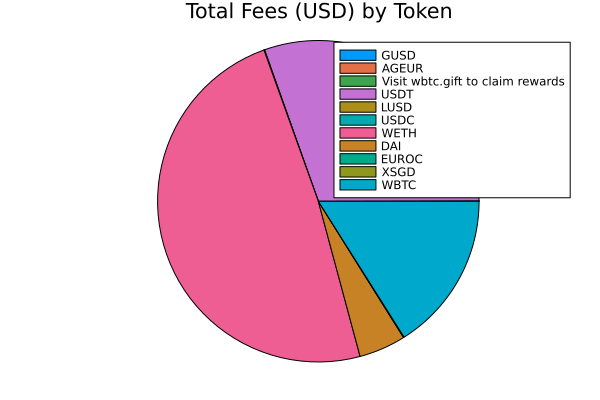

In [7]:
using Plots

# Extract keys and values from the dictionary
tokens = collect(keys(total_value_by_token)) 
values = [total_value_by_token[token] for token in tokens]

# Plot pie chart
pie(tokens, values, title = "Total Fees (USD) by Token")
